# Circle dataset — Diffusion model inference (trained model)

This notebook loads a pre-trained Diffusion posterior sampler and performs inference on the circle dataset. Configure `load_path`, `epochs`, and `seed` to match your saved checkpoint names.


In [57]:
from pathlib import Path
import sys
# Project path setup
project_root = Path.cwd()
if (project_root / 'src').exists():
    pass
else:
    # Fallback: user-specific path
    project_root = Path('/home/chu034/Yaohang_Li/cDiff')


if not project_root.exists() or not (project_root / 'src').exists():
    raise FileNotFoundError(f"找不到项目目录或 src: {project_root}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"项目路径: {project_root}")
print("Python 路径已更新")


项目路径: /home/chu034/Yaohang_Li/cDiff
Python 路径已更新


In [58]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets.circle import return_circle_dl, set_circle_noise_sigma
from models.neural_sampler import DiffusionPosteriorSampler
from utils import load_torch_model, SET_SEED

# ----- Config -----
# Match these with your training run
load_path = "/home/chu034/Yaohang_Li/cDiff/result/circle"   # --save_path result --dataset circle
epochs = 40                  # --epochs 5000
seed = 1                       # pick a trained seed in [1..10] per your run
model_type = "Diffusion"       # --model Diffusion (nickname if any was appended during training)

# Device config
cuda_index = 0                 # --device 0
DEVICE = torch.device(f"cuda:{cuda_index}" if torch.cuda.is_available() else "cpu")

# Data config
n_batches = 2
batch_size = 512
n_sample = None  # encoder ON in training; dataset returns variable set sizes
noise_sigma = 0.0  # optional: add noise to observed radius values

# Reproducibility for sampling/plotting
SET_SEED(42)

# Optional: set noise level used to generate observed radii (y)
set_circle_noise_sigma(noise_sigma)
print(f"Using device: {DEVICE}")


Using device: cuda:0


In [59]:
# Build a small dataloader and fetch one batch
# 原来是 0.0
noise_sigma = 10e-6
set_circle_noise_sigma(noise_sigma)

# 之后再创建 dataloader
dl, ds = return_circle_dl(n_batches=n_batches, batch_size=batch_size, n_sample=n_sample, return_ds=True)

theta_true, y_obs = next(iter(dl))  # theta_true: [B, 2], y_obs: [B, set_size, 1]
print("theta_true shape:", theta_true.shape)
print("y_obs shape:", y_obs.shape)

y_dim = y_obs.shape[-1]
x_dim = theta_true.shape[1]
print(f"y_dim={y_dim}, x_dim={x_dim}")


theta_true shape: torch.Size([512, 2])
y_obs shape: torch.Size([512, 960, 1])
y_dim=1, x_dim=2


In [60]:
# Reconstruct model architecture; must match training config
n_summaries = 256          # from main.py
num_hidden_layer = 4       # default training arg
use_encoder = False         # you trained with --use_encoder
sigma_data = 0.5           # you likely used default (unless --use_emperical_sigma was set)

model = DiffusionPosteriorSampler(
    y_dim=y_dim,
    x_dim=x_dim,
    n_summaries=n_summaries,
    num_hidden_layer=num_hidden_layer,
    device=DEVICE,
    use_encoder=use_encoder,
    data_type="iid",
    sigma_data=sigma_data,
).to(DEVICE)

# Load weights — filenames are: {load_path}/{epochs}_seed={seed}_{model_type}.pth
model = load_torch_model(model, load_path, epochs, seed, model_type)
_ = model.to(DEVICE).eval()

print("Model loaded and ready.")


Model loaded from /home/chu034/Yaohang_Li/cDiff/result/circle/40_seed=1_Diffusion.pth
Model loaded and ready.


In [62]:
# Run inference: posterior samples of theta given observed y
# 1) 输入是否含 NaN/Inf
print("NaN in y_obs:", torch.isnan(y_obs).any().item(), "Inf in y_obs:", torch.isinf(y_obs).any().item())

# # 2) 编码后的摘要 s 是否含 NaN（只测 encoder）
# with torch.no_grad():
#     s = model.summary(y_obs.to(DEVICE)) if model.use_encoder else y_obs.to(DEVICE)
# print("NaN in summary s:", torch.isnan(s).any().item(), "Inf in s:", torch.isinf(s).any().item())
y_batch = y_obs.to(DEVICE)
with torch.no_grad():
    theta_est = model.sample(y_batch, num_steps=20)  # [B, 2]


NaN in y_obs: False Inf in y_obs: False


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [ ]:
theta_est

tensor([[-0.8042, -1.1992],
        [-0.3637,  0.4161],
        [-0.0714,  0.9392],
        ...,
        [-0.1712,  1.3672],
        [-0.8912,  0.8299],
        [-0.2473,  1.0320]], device='cuda:0')

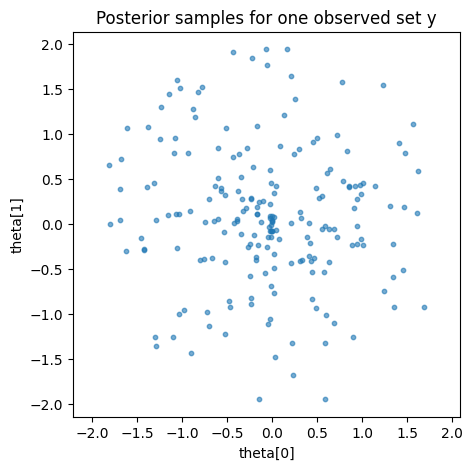

In [ ]:

theta_est_cpu = theta_est.detach().cpu().numpy()
theta_true_cpu = theta_true.detach().cpu().numpy()

# # Scatter: true theta vs estimated theta per dim
# plt.figure(figsize=(10, 4))
# for i in range(x_dim):
#     plt.subplot(1, x_dim, i + 1)
#     plt.scatter(theta_true_cpu[:, i], theta_est_cpu[:, i], s=10, alpha=0.5)
#     plt.xlabel(f"True theta[{i}]")
#     plt.ylabel(f"Est theta[{i}]")
#     plt.title(f"Dim {i}")
# plt.tight_layout()
# plt.show()

# Optional: visualize samples for one observed set y
idx = 0
one_y = y_batch[idx:idx+1]
with torch.no_grad():
    samples = model.sample(one_y, num_steps=18)  # [1, 2]

# For visualization, draw multiple samples by repeating the same condition
with torch.no_grad():
    cond = one_y.repeat(200, 1, 1)  # 200 posterior samples
    samples_many = model.sample(cond, num_steps=50).detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(samples_many[:, 0], samples_many[:, 1], s=10, alpha=0.6)
plt.xlabel("theta[0]")
plt.ylabel("theta[1]")
plt.title("Posterior samples for one observed set y")
plt.axis('equal')
plt.show()


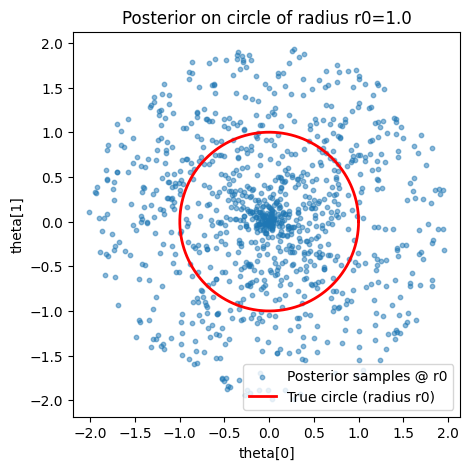

In [ ]:
# Plot posterior samples for a specific target radius r0 and overlay the true circle

import numpy as np

# Choose the target radius
r0 = 1.0  # change this as you like

# Build a conditional set y with the same set size the encoder expects
set_size = y_obs.shape[1]
one_y = torch.full((1, set_size, 1), r0, device=DEVICE)

# Add tiny perturbation to avoid zero-variance set in encoder
epsilon = 1e-6  # tweak if needed
one_y = one_y + epsilon * torch.randn_like(one_y)

# Draw many posterior samples conditioned on r0
num_samples = 1000
with torch.no_grad():
    cond = one_y.repeat(num_samples, 1, 1)
    samples_r = model.sample(cond, num_steps=50).detach().cpu().numpy()



plt.figure(figsize=(5, 5))
plt.scatter(samples_r[:, 0], samples_r[:, 1], s=10, alpha=0.5, label='Posterior samples @ r0')
plt.plot(true_x, true_y, 'r-', linewidth=2.0, label='True circle (radius r0)')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')
plt.title(f'Posterior on circle of radius r0={r0}')
plt.axis('equal')
plt.legend()
plt.show()


# non-encoder

In [7]:
from pathlib import Path
import sys

# Project path setup
project_root = Path.cwd()
if (project_root / 'src').exists():
    pass
else:
    # Fallback: user-specific path
    project_root = Path('/home/chu034/Yaohang_Li/cDiff')


if not project_root.exists() or not (project_root / 'src').exists():
    raise FileNotFoundError(f"找不到项目目录或 src: {project_root}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"项目路径: {project_root}")
print("Python 路径已更新")


项目路径: /home/chu034/Yaohang_Li/cDiff
Python 路径已更新


In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets.circle import return_circle_dl, set_circle_noise_sigma
from models.neural_sampler import DiffusionPosteriorSampler
from utils import load_torch_model, SET_SEED

# ----- Config -----
# Match these with your training run
load_path = "/home/chu034/Yaohang_Li/cDiff/result/circle"   # --save_path result --dataset circle
epochs = 3000                   # --epochs 5000
seed = 1                       # pick a trained seed in [1..10] per your run
model_type = "Diffusion"       # --model Diffusion (nickname if any was appended during training)

# Device config
cuda_index = 0                 # --device 0
DEVICE = torch.device(f"cuda:{cuda_index}" if torch.cuda.is_available() else "cpu")

# Data config
n_batches = 200
batch_size = 128
n_sample = None  # encoder ON in training; dataset returns variable set sizes
noise_sigma = 0.0  # optional: add noise to observed radius values

# Reproducibility for sampling/plotting
SET_SEED(42)

# Optional: set noise level used to generate observed radii (y)
set_circle_noise_sigma(noise_sigma)
print(f"Using device: {DEVICE}")


Using device: cuda:0


In [9]:
# Build a small dataloader and fetch one batch
# 原来是 0.0
noise_sigma = 0.0
set_circle_noise_sigma(noise_sigma)

# 之后再创建 dataloader
dl, ds = return_circle_dl(n_batches=n_batches, batch_size=batch_size, n_sample=n_sample, return_ds=True)

theta_true, y_obs = next(iter(dl))  # theta_true: [B, 2], y_obs: [B, set_size, 1]
print("theta_true shape:", theta_true.shape)
print("y_obs shape:", y_obs.shape)

y_dim = y_obs.shape[-1]
x_dim = theta_true.shape[1]
print(f"y_dim={y_dim}, x_dim={x_dim}")


theta_true shape: torch.Size([128, 2])
y_obs shape: torch.Size([128, 342, 1])
y_dim=1, x_dim=2


In [10]:
theta_true.std().item()

0.8220995664596558

In [11]:
# No-encoder test: collapse y to scalar radius and instantiate a no-encoder model

# Prepare scalar radius per item: mean over set dimension -> shape [B, 1]
y_scalar = y_obs.mean(dim=1)  # [B, 1]

# Build model without encoder (cannot load encoder-trained weights)
model_noenc = DiffusionPosteriorSampler(
    y_dim=1,
    x_dim=x_dim,
    n_summaries=1,
    num_hidden_layer=4,
    device=DEVICE,
    use_encoder=False,
    data_type="iid",
    sigma_data=0.5,
).to(DEVICE).eval()
model_noenc = load_torch_model(model_noenc, load_path, epochs, seed, model_type)
_ = model_noenc.to(DEVICE).eval()




Model loaded from /home/chu034/Yaohang_Li/cDiff/result/circle/3000_seed=1_Diffusion.pth


/home/chu034/Yaohang_Li/cDiff/utils.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_name))


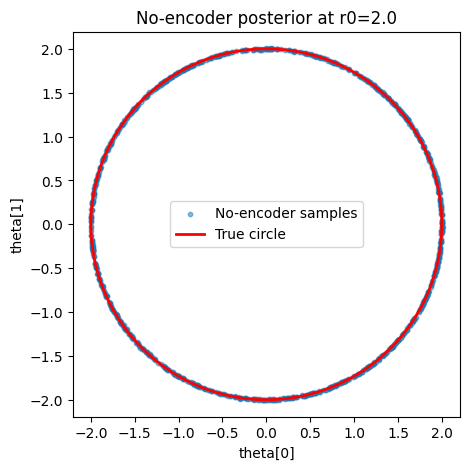

In [14]:
# No-encoder: sample at specific radius r0 and overlay true circle

import numpy as np

r0_noenc = 2.0
num_samples = 1000

with torch.no_grad():
    cond_noenc = torch.full((num_samples, 1), r0_noenc, device=DEVICE)
    samples_noenc = model_noenc.sample(cond_noenc, num_steps=100).detach().cpu().numpy()

ang = np.linspace(0, 2*np.pi, 400)
true_x = r0_noenc * np.cos(ang)
true_y = r0_noenc * np.sin(ang)

plt.figure(figsize=(5,5))
plt.scatter(samples_noenc[:,0], samples_noenc[:,1], s=10, alpha=0.5, label='No-encoder samples')
plt.plot(true_x, true_y, 'r-', lw=2, label='True circle')
plt.axis('equal')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')
plt.title(f'No-encoder posterior at r0={r0_noenc}')
plt.legend()
plt.show()
